# Analyse Tokeniser 

This notebook calculates the input lengths post bert tokenisation

In [1]:
model_dir = "../temp_data/"
bucket = "aegovan-data"
trainfile = "s3://{}/processed_dataset/train_multiclass.json".format(bucket)
testfile = "s3://{}/processed_dataset/test_multiclass.json".format(bucket)
valfile = "s3://{}/processed_dataset/val_multiclass.json".format(bucket)

valfile_prediction = "s3://aegovan-data/pubmed_asbtract/predictions_valtest_ppimulticlass-bert-f1-2021-05-10-9_2021051105/val_multiclass.json.json".format(bucket)
testfile_prediction = "s3://aegovan-data/pubmed_asbtract/predictions_valtest_ppimulticlass-bert-f1-2021-05-10-9_2021051105/test_multiclass.json.json".format(bucket)





column="normalised_abstract"


In [2]:
import os, sys
sys.path.append("../src")

In [3]:
from transformers import BertTokenizer
from datasets.transformer_chain import TransformerChain
from datasets.transformer_name_normaliser import TransformerNameNormaliser
from datasets.transformer_ppi_participant_augmentor import TransformerPPIParticipantAugmentor


tokeniser = BertTokenizer.from_pretrained(model_dir, do_lower_case=False)

transformer_list = [
            TransformerPPIParticipantAugmentor(participant1_key="participant1Id"
                                               , participant2_key="participant2Id"
                                               , annotations_dict_key="normalised_abstract_annotations"
                                               , result_key_participant="participantEntities"
                                               , result_key_other="otherEntities"
                                               ),
            TransformerNameNormaliser(text_key="normalised_abstract",
                                      participants_entities_dict_key="participantEntities",
                                      other_entities_dict_key="otherEntities",
                                      random_seed=42),
           lambda x:tokeniser.tokenize(x)
        ]

       

transformer_chain = TransformerChain(transformer_list)


In [4]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)



In [5]:
import json
import pandas as pd


def get_counts(input_file, column):
    data = pd.read_json(input_file)
            
    counts = []
    
    data["tokens"] =  data.apply (lambda x:  transformer_chain(x.to_dict()), axis=1)
    data["token_len"] = data.apply (lambda x:  len(x["tokens"]), axis=1)
    return data

def get_counts_unique(input_file, column):
    data = pd.read_json(input_file)
            
    pubmed_abstracts = data.drop_duplicates(subset=[column])
    
    
    result = pd.DataFrame()
    
    result["tokens"] =  pubmed_abstracts.apply (lambda x:  transformer_chain(x.to_dict()), axis=1)
    result["token_len"] = result.apply (lambda x:  len(x["tokens"]), axis=1)
    return result

In [6]:
import os

def download_and_get_counts(s3_file):
    local_file = os.path.join(".", s3_file.split("/")[-1] )
    download_single_file(s3_file, local_file) 
    df = get_counts (local_file, column)
    df_unique = get_counts_unique (local_file, column)
    
    return df, df_unique
    


In [7]:
df_train, df_train_unique  = download_and_get_counts(trainfile)

df_train["token_len"].describe(percentiles=[i/100 for i in range(0,100,10)])

count    1305.000000
mean      378.209195
std        95.530605
min       174.000000
0%        174.000000
10%       256.000000
20%       285.000000
30%       323.000000
40%       344.600000
50%       377.000000
60%       402.000000
70%       426.000000
80%       464.000000
90%       511.000000
max       612.000000
Name: token_len, dtype: float64

In [8]:
df_train_unique["token_len"].describe(percentiles=[i/100 for i in range(0,100,10)])

count    167.000000
mean     354.562874
std       98.217765
min      177.000000
0%       177.000000
10%      229.600000
20%      264.200000
30%      298.200000
40%      327.000000
50%      344.000000
60%      369.800000
70%      407.200000
80%      437.800000
90%      485.400000
max      612.000000
Name: token_len, dtype: float64

In [9]:
df_test, df_test_unique  = download_and_get_counts(testfile)
df_test_unique["token_len"].describe(percentiles=[i/100 for i in range(0,100,10)])

count     42.000000
mean     333.357143
std      100.921805
min      177.000000
0%       177.000000
10%      226.200000
20%      237.000000
30%      258.900000
40%      289.400000
50%      323.500000
60%      355.800000
70%      391.200000
80%      421.400000
90%      462.700000
max      538.000000
Name: token_len, dtype: float64

In [10]:
df_test["token_len"].describe(percentiles=[i/100 for i in range(0,100,10)])

count    352.000000
mean     353.213068
std      102.591340
min      175.000000
0%       175.000000
10%      209.200000
20%      250.200000
30%      296.300000
40%      323.000000
50%      348.000000
60%      376.000000
70%      414.700000
80%      447.000000
90%      496.900000
max      538.000000
Name: token_len, dtype: float64

In [11]:
df_val, df_val_unique  = download_and_get_counts(valfile)
df_val_unique["token_len"].describe(percentiles=[i/100 for i in range(0,100,10)])

count     24.000000
mean     356.583333
std       85.539676
min      198.000000
0%       198.000000
10%      252.400000
20%      284.600000
30%      324.300000
40%      334.800000
50%      349.500000
60%      376.600000
70%      395.600000
80%      437.600000
90%      472.200000
max      496.000000
Name: token_len, dtype: float64

In [12]:
df_val["token_len"].describe(percentiles=[i/100 for i in range(0,100,10)])

count    200.000000
mean     375.320000
std       78.162488
min      194.000000
0%       194.000000
10%      241.900000
20%      323.000000
30%      335.000000
40%      361.800000
50%      379.000000
60%      389.000000
70%      420.900000
80%      467.000000
90%      472.000000
max      496.000000
Name: token_len, dtype: float64

In [13]:
df = pd.DataFrame()
df["train_unique"] = df_train_unique["token_len"].describe(percentiles=[i/100 for i in range(0,100,10)])
df["test_unique"] = df_test_unique["token_len"].describe(percentiles=[i/100 for i in range(0,100,10)])
df["val_unique"] = df_val_unique["token_len"].describe(percentiles=[i/100 for i in range(0,100,10)])

In [14]:
print(df.round(2).to_latex())


\begin{tabular}{lrrr}
\toprule
{} &  train\_unique &  test\_unique &  val\_unique \\
\midrule
count &        167.00 &        42.00 &       24.00 \\
mean  &        354.56 &       333.36 &      356.58 \\
std   &         98.22 &       100.92 &       85.54 \\
min   &        177.00 &       177.00 &      198.00 \\
0\%    &        177.00 &       177.00 &      198.00 \\
10\%   &        229.60 &       226.20 &      252.40 \\
20\%   &        264.20 &       237.00 &      284.60 \\
30\%   &        298.20 &       258.90 &      324.30 \\
40\%   &        327.00 &       289.40 &      334.80 \\
50\%   &        344.00 &       323.50 &      349.50 \\
60\%   &        369.80 &       355.80 &      376.60 \\
70\%   &        407.20 &       391.20 &      395.60 \\
80\%   &        437.80 &       421.40 &      437.60 \\
90\%   &        485.40 &       462.70 &      472.20 \\
max   &        612.00 &       538.00 &      496.00 \\
\bottomrule
\end{tabular}



In [15]:
df = pd.DataFrame()
df["train"] = df_train["token_len"].describe(percentiles=[i/100 for i in range(0,100,10)])
df["test"] = df_test["token_len"].describe(percentiles=[i/100 for i in range(0,100,10)])
df["val"] = df_val["token_len"].describe(percentiles=[i/100 for i in range(0,100,10)])
print(df.round(2).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &    train &    test &     val \\
\midrule
count &  1305.00 &  352.00 &  200.00 \\
mean  &   378.21 &  353.21 &  375.32 \\
std   &    95.53 &  102.59 &   78.16 \\
min   &   174.00 &  175.00 &  194.00 \\
0\%    &   174.00 &  175.00 &  194.00 \\
10\%   &   256.00 &  209.20 &  241.90 \\
20\%   &   285.00 &  250.20 &  323.00 \\
30\%   &   323.00 &  296.30 &  335.00 \\
40\%   &   344.60 &  323.00 &  361.80 \\
50\%   &   377.00 &  348.00 &  379.00 \\
60\%   &   402.00 &  376.00 &  389.00 \\
70\%   &   426.00 &  414.70 &  420.90 \\
80\%   &   464.00 &  447.00 &  467.00 \\
90\%   &   511.00 &  496.90 &  472.00 \\
max   &   612.00 &  538.00 &  496.00 \\
\bottomrule
\end{tabular}



### Prediction Analysis on Seq length

In [16]:
df_prediction, _ = download_and_get_counts(testfile_prediction) 

In [17]:
from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score

def get_scores(df, actual, predicted, labels=None):

    f1 = f1_score(df[actual], df[predicted], average='macro' ,sample_weight=None, labels=labels)  
    p = precision_score(df[actual], df[predicted], average='macro' ,sample_weight=None)  
    r = recall_score(df[actual], df[ predicted], average='macro' ,sample_weight=None)  

    return f1,p,r

def plot_confusion_matrix(df, actual, predicted, save_file=None):
    import matplotlib.pyplot as plt
    import scikitplot as skplt


    skplt.metrics.plot_confusion_matrix(df[actual], df[predicted], normalize=True , figsize=(4,4),  x_tick_rotation=90)
  

    skplt.metrics.plot_confusion_matrix(df[actual], df[predicted], figsize=(4,4), normalize=False,x_tick_rotation=90 )
    
    if save_file:
        plt.savefig(save_file, bbox_inches="tight")
    
    plt.show()


In [18]:
positive_labels = list(set(df_prediction["class"].unique().tolist()) - set("other"))

In [19]:
df_prediction.shape

(352, 22)

In [20]:
get_scores ( df_prediction.query("token_len > 510"), "class" , "prediction")



/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.45555555555555555, 0.43333333333333335, 0.48888888888888893)

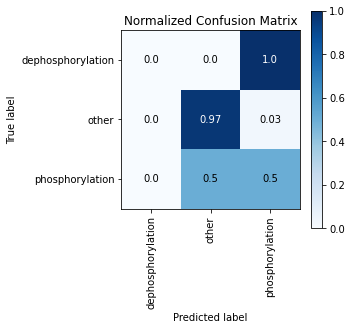

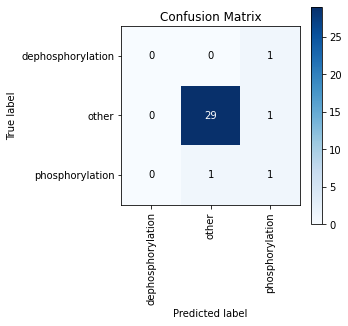

In [21]:
plot_confusion_matrix(df_prediction.query("token_len > 510"), "class" , "prediction", "len_long_confusion.png")


In [22]:
get_scores ( df_prediction.query("token_len > 510"), "class" , "prediction", positive_labels)



/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.22777777777777777, 0.43333333333333335, 0.48888888888888893)

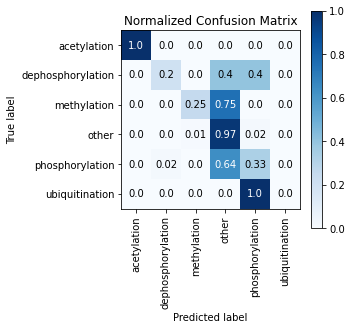

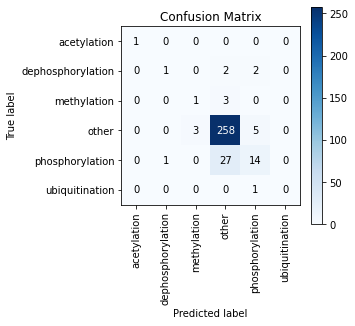

In [23]:
plot_confusion_matrix(df_prediction.query("token_len < 510"), "class" , "prediction", "len_short_confusion.png")



In [24]:
df_prediction.query("token_len > 510").groupby( ["class" , "prediction"])["class" , "prediction"].count()

/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


class  prediction
class             prediction                        
dephosphorylation phosphorylation      1           1
other             other               29          29
                  phosphorylation      1           1
phosphorylation   other                1           1
                  phosphorylation      1           1

In [25]:
df_prediction.shape

(352, 22)

In [26]:
df_prediction.query("token_len >= 510")["normalised_abstract"].nunique()

3

In [27]:
df_prediction.query("token_len < 510")["normalised_abstract"].nunique()

39

In [28]:
df_prediction.query("token_len >= 510").shape

(33, 22)

In [29]:
get_scores ( df_prediction.query("token_len < 510"), "class" , "prediction")

/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.4835453066118534, 0.5460031347962382, 0.4588763575605681)

In [30]:
get_scores ( df_prediction.query("token_len > 10"), "class" , "prediction", positive_labels)

/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.47776679841897235, 0.5411458333333333, 0.454528392028392)

In [31]:
get_scores ( df_prediction, "class" , "prediction")

/Users/aeg/venv/ppi-aimed/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.47776679841897235, 0.5411458333333333, 0.454528392028392)